# ***Setting up GPU and Fastai***

In [1]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 18.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [2]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.5 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 189 kB 48.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x558cfb79e000 @  0x7f3851454615 0x558cc132c4cc 0x558cc140c47a 0x558cc132f2ed 0x558cc1420e1d 0x558cc13a2e99 0x558cc139d9ee 0x558cc1330bda 0x558cc13a2d00 0x558cc139d9ee 0x558cc1330bda 0x558cc139f737 0x558cc1421c66 0x558cc139edaf 0x558cc1421c66 0x558cc139edaf 0x558cc1421c66 0x558cc139edaf 0x558cc1331039 0x558cc1374409 0x558cc132fc52 0x558cc13a2c25 0x558cc139d9ee 0x558cc1330bda 0x558cc139f737 0x558cc139d9ee 0x558cc1330bda 0x558cc139e915 0x558cc1330afa 0x558cc139ec0d 0x558cc139d9ee
     |████████████████████████████████| 881.9 MB 2.0 kB/s 
     |████████████████████████████████| 23.2 MB 57.0 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
   

In [4]:
from fastbook import *

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# ***Cnn_learner for image classification***

Import all fastai.vision library

In [6]:
from fastai.vision.all import *

The fastai library doesn't just return a string containing the path to the dataset, but a Path object. This is a really useful class from the Python 3 standard library that makes accessing files and directories much easier. 

In [7]:
path = untar_data(URLs.PETS)/'images'

In [8]:
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.173641,0.014472,0.003383,01:31


epoch,train_loss,valid_loss,error_rate,time
0,0.059637,0.013628,0.004736,02:06


# ***Unet_learner for segmentation***

In [9]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,2.749570,2.195619,00:04


epoch,train_loss,valid_loss,time
0,1.735936,1.478853,00:04
1,1.502532,1.399184,00:04
2,1.349677,1.109790,00:04
3,1.201620,0.992497,00:04
4,1.088622,0.837557,00:04
5,0.990939,0.793204,00:04
6,0.909678,0.778110,00:04
7,0.844294,0.758111,00:04


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


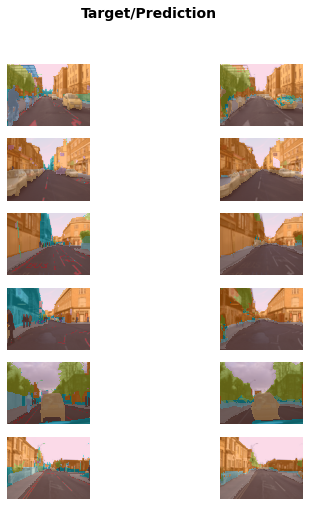

In [10]:
learn.show_results(max_n=6, figsize=(7,8))

# ***Text_classifier_learner for sentiment analysis***

In [11]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.457466,0.400032,0.822200,07:13


epoch,train_loss,valid_loss,accuracy,time
0,0.314004,0.253661,0.898360,13:58
1,0.254880,0.204813,0.920520,13:58
2,0.180236,0.194086,0.925680,13:59
3,0.145163,0.191106,0.928320,13:59


In [12]:
learn.predict("I don't want to watch that movie again!")

('pos', TensorText(1), TensorText([0.0178, 0.9822]))

# ***Tabular_learner for decisiontree***

In [13]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [14]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.382590,0.360596,0.830620,00:06
1,0.354725,0.351235,0.837224,00:06
2,0.360822,0.347955,0.838759,00:06


# ***Collab_learner for ranking***

In [15]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.519207,1.413368,00:00


epoch,train_loss,valid_loss,time
0,1.388155,1.359782,00:00
1,1.294653,1.193021,00:00
2,1.049291,0.891161,00:00
3,0.825404,0.737101,00:00
4,0.701211,0.699669,00:00
5,0.646747,0.688687,00:00
6,0.618522,0.683482,00:00
7,0.600537,0.680893,00:00
8,0.609770,0.680110,00:00
9,0.594119,0.679964,00:00


In [16]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,38.0,95.0,3.5,4.402937
1,53.0,49.0,5.0,4.268655
2,41.0,49.0,4.0,4.011588
3,24.0,1.0,4.0,3.606720
4,72.0,40.0,3.5,2.999226
5,62.0,44.0,3.0,3.019116
6,14.0,18.0,3.0,4.017102
7,27.0,68.0,1.5,3.370472
8,16.0,63.0,4.0,4.526047
